<a href="https://colab.research.google.com/github/tonchan1216/bitbot/blob/master/predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install fbprophet

## Import and Def

In [1]:
import pandas as pd
from fbprophet import Prophet
from fbprophet import plot
from fbprophet.diagnostics import cross_validation, performance_metrics
from datetime import datetime, timedelta
import requests,time
import itertools

In [2]:
def get_OHLC(before,after):
    duration = 86400
    url = 'https://api.cryptowat.ch/markets/bitflyer/btcjpy/ohlc'
    query = {
        'periods':duration,
        'before': get_UTC(before),
        'after': get_UTC(after),
        }
    res = requests.get(url,params=query).json()
    if ('error' in res):
        raise Exception(res['error'])

    Time,Open,High,Low,Close,Volume = [],[],[],[],[],[]
    for i in res['result'][str(duration)]:
        Time.append(datetime.fromtimestamp(i[0]).strftime('%Y-%m-%d'))
        Open.append(i[1])
        High.append(i[2])
        Low.append(i[3])
        Close.append(i[4])
        Volume.append(i[5])

    return pd.DataFrame(
        {'ds':Time, 'y':Close})

def get_UTC(dt):
    return int(datetime.strptime(dt, '%Y-%m-%d %H:%M %z').timestamp())

## データの取得

In [30]:
start_time = '2015-1-01 12:00 +0900'
end_time = '2021-12-30 12:00 +0900'
ohlc = get_OHLC(end_time, start_time)
print(ohlc)

              ds        y
0     2015-06-26    32000
1     2015-06-27    31700
2     2015-06-28    31000
3     2015-06-29    30870
4     2015-06-30    31550
...          ...      ...
2374  2021-12-26  5768595
2375  2021-12-27  5808996
2376  2021-12-28  5820883
2377  2021-12-29  5456831
2378  2021-12-30  5343060

[2379 rows x 2 columns]


## 学習

In [31]:
param_grid = {  
    "yearly_seasonality": [True],
    "weekly_seasonality": [False],
    "daily_seasonality": [True],
    'changepoint_prior_scale': [5.0],
    'seasonality_prior_scale': [1.9],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mdls = [Prophet(**p) for p in all_params]
for i,m in enumerate(mdls):
  m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
       
for i, m in enumerate(mdls):
    print("PROGRESS: " + str(i+1) + '/' + str(len(mdls)))
    m.fit(ohlc)

PROGRESS: 1/1


## 予測

In [32]:
# 予測値を格納するためのDataFrameを作成し、予測
preds = []
for i, m in enumerate(mdls):
  future = m.make_future_dataframe(periods=3)
  forecast = m.predict(future)
  preds.append(forecast)

## 可視化

In [33]:
plot.plot_plotly(mdls[0], preds[0])

In [29]:
plot.plot_components_plotly(mdls[0], preds[0])

## クロスバリデーションの実行

In [20]:
# 評価
metrics = []
for i, m in enumerate(mdls):
  print("PROGRESS: " + str(i+1) + '/' + str(len(mdls)))
  df_cv = cross_validation(m, initial='365.25 days', period='45 days', horizon = '3 days')
  df_p = performance_metrics(df_cv, rolling_window=0.1)
  tmp = df_p[['mape']].rename({'mape': str(i)}, axis=1)
  metrics.append(tmp)

INFO:fbprophet:Making 45 forecasts with cutoffs between 2016-07-16 00:00:00 and 2021-12-17 00:00:00


PROGRESS: 1/3


  0%|          | 0/45 [00:00<?, ?it/s]

PROGRESS: 2/3


INFO:fbprophet:Making 45 forecasts with cutoffs between 2016-07-16 00:00:00 and 2021-12-17 00:00:00


  0%|          | 0/45 [00:00<?, ?it/s]

INFO:fbprophet:Making 45 forecasts with cutoffs between 2016-07-16 00:00:00 and 2021-12-17 00:00:00


PROGRESS: 3/3


  0%|          | 0/45 [00:00<?, ?it/s]

## 結果の確認


{'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'changepoint_prior_scale': 5.0, 'seasonality_prior_scale': 1.85}
{'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'changepoint_prior_scale': 5.0, 'seasonality_prior_scale': 1.9}
{'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'changepoint_prior_scale': 5.0, 'seasonality_prior_scale': 1.95}
          0         1         2
0  0.094717  0.090796  0.096800
1  0.112296  0.107596  0.113883
2  0.113331  0.108952  0.116186


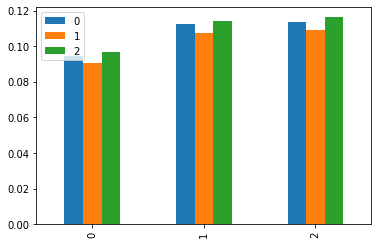

In [21]:
for x in all_params:
  print(x)

res = pd.concat(metrics,axis=1)
print(res)
res.plot.bar()